In [2]:
import numpy as np 
import pandas as pd
import neattext.functions as nfx
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import BatchNormalization, LSTM, Dropout, GlobalMaxPooling1D, Embedding, Input, Dense
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tqdm import tqdm
import pickle

tf.config.list_physical_devices('GPU')

[]

In [3]:
data=pd.read_csv('../dataset/Suicide_Detection.csv')

In [ ]:
data.shape

(232074, 3)

In [4]:
train_data,test_data=train_test_split(data,test_size=0.2,random_state=np.random.randint(10))

In [6]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for str in tqdm(text):
        str=str.lower()
        str=nfx.remove_emails(str)
        str=nfx.remove_urls(str)
        str=nfx.remove_special_characters(str)
        str=nfx.remove_stopwords(str)
        text_length.append(len(str.split()))
        cleaned_text.append(str)
    return cleaned_text,text_length

In [7]:
cleaned_train_text, train_text_length = clean_text(train_data.text)
cleaned_test_text, test_text_length = clean_text(test_data.text)

100%|██████████| 46415/46415 [00:04<00:00, 9670.49it/s] 


In [8]:
tokenizer=Tokenizer(num_words=170428)
tokenizer.fit_on_texts(cleaned_train_text)

word_frequency = pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)
print(word_frequency[20:40])

        word  count
71      good  36480
633  fucking  36349
195   school  35432
477      way  34764
110  anymore  32935
820     need  32484
358    didnt  32145
36    family  31052
297   better  31033
107      die  30283
289      end  29976
43      love  29866
338     talk  29835
137     live  29439
502     kill  29007
273     fuck  28754
356     year  27934
492      ill  27839
505  suicide  27755
55     right  27436


In [9]:
tokenizer.word_index

{'im': 1,
 'dont': 2,
 'like': 3,
 'want': 4,
 'know': 5,
 'feel': 6,
 'life': 7,
 'ive': 8,
 'cant': 9,
 'people': 10,
 'time': 11,
 'think': 12,
 'going': 13,
 'friends': 14,
 'day': 15,
 'help': 16,
 'years': 17,
 'filler': 18,
 'things': 19,
 'got': 20,
 'good': 21,
 'fucking': 22,
 'school': 23,
 'way': 24,
 'anymore': 25,
 'need': 26,
 'didnt': 27,
 'family': 28,
 'better': 29,
 'die': 30,
 'end': 31,
 'love': 32,
 'talk': 33,
 'live': 34,
 'kill': 35,
 'fuck': 36,
 'year': 37,
 'ill': 38,
 'suicide': 39,
 'right': 40,
 'hate': 41,
 'shit': 42,
 'work': 43,
 'thing': 44,
 'bad': 45,
 'parents': 46,
 'person': 47,
 'told': 48,
 'friend': 49,
 'thats': 50,
 'care': 51,
 'tell': 52,
 'thought': 53,
 'said': 54,
 'point': 55,
 'doesnt': 56,
 'tried': 57,
 'getting': 58,
 'try': 59,
 'happy': 60,
 'job': 61,
 'long': 62,
 'feeling': 63,
 'mom': 64,
 'away': 65,
 'find': 66,
 'trying': 67,
 'lot': 68,
 'wanted': 69,
 'pain': 70,
 'started': 71,
 'best': 72,
 'tired': 73,
 'hard': 74,
 

# Process Text For the Model

In [10]:
train_text_seq= tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad= pad_sequences(train_text_seq,maxlen=100)

test_text_seq= tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad= pad_sequences(test_text_seq,maxlen=100)

In [11]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

# Embedding Model 

In [12]:
with open('../dataset/glove.840B.300d.pkl', 'rb') as fp:
    glove = pickle.load(fp)

In [13]:
dataset_length=len(tokenizer.word_index) + 1

embedding_matrix=np.zeros((dataset_length,300), dtype=float) #pad 0 to prep the matrix to match with the shape of our dataset
for word,i in tokenizer.word_index.items():
    num = glove.get(word)
    if num is not None:
        embedding_matrix[i] = num

# Model Building

In [14]:
model=tf.keras.models.Sequential()
model.add(Input(shape=(100,)))
model.add(Embedding(dataset_length,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dense(200,activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=keras.optimizers.SGD(0.01,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          78603600  
                                                                 
 lstm (LSTM)                 (None, 100, 20)           25680     
                                                                 
 global_max_pooling1d (Globa  (None, 20)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 200)               4200      
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 78,633,681
Trainable params: 30,081
Non-trainable params: 78,603,600
_______________________________________

In [15]:
early_break = EarlyStopping(monitor='loss', patience=5)
reduce_learning_rate = ReduceLROnPlateau(patience=3)

result=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=200,callbacks=[early_break,reduce_learning_rate])

Epoch 1/20
929/929 [==============================] - 50s 53ms/step - loss: 0.5166 - accuracy: 0.7870 - val_loss: 0.3497 - val_accuracy: 0.8677 - lr: 0.0100
Epoch 2/20
929/929 [==============================] - 50s 54ms/step - loss: 0.3044 - accuracy: 0.8827 - val_loss: 0.3044 - val_accuracy: 0.8767 - lr: 0.0100
Epoch 3/20
929/929 [==============================] - 49s 53ms/step - loss: 0.2696 - accuracy: 0.8946 - val_loss: 0.2565 - val_accuracy: 0.9003 - lr: 0.0100
Epoch 4/20
929/929 [==============================] - 48s 52ms/step - loss: 0.2540 - accuracy: 0.9009 - val_loss: 0.2400 - val_accuracy: 0.9066 - lr: 0.0100
Epoch 5/20
929/929 [==============================] - 45s 49ms/step - loss: 0.2436 - accuracy: 0.9046 - val_loss: 0.2340 - val_accuracy: 0.9087 - lr: 0.0100
Epoch 6/20
929/929 [==============================] - 45s 48ms/step - loss: 0.2365 - accuracy: 0.9078 - val_loss: 0.2387 - val_accuracy: 0.9061 - lr: 0.0100
Epoch 7/20
929/929 [==============================] - 45s 

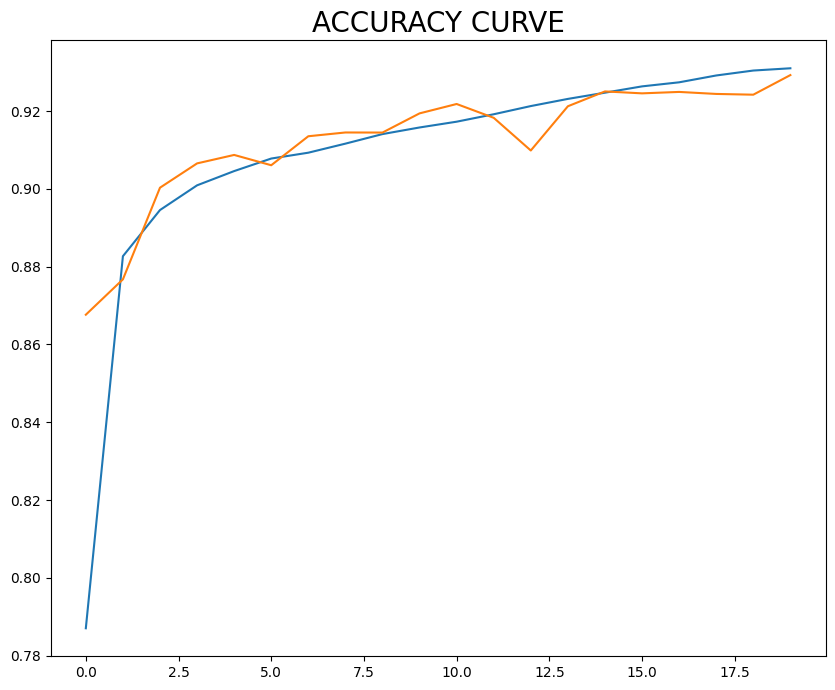

In [16]:
plt.figure(figsize=(10,8))
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

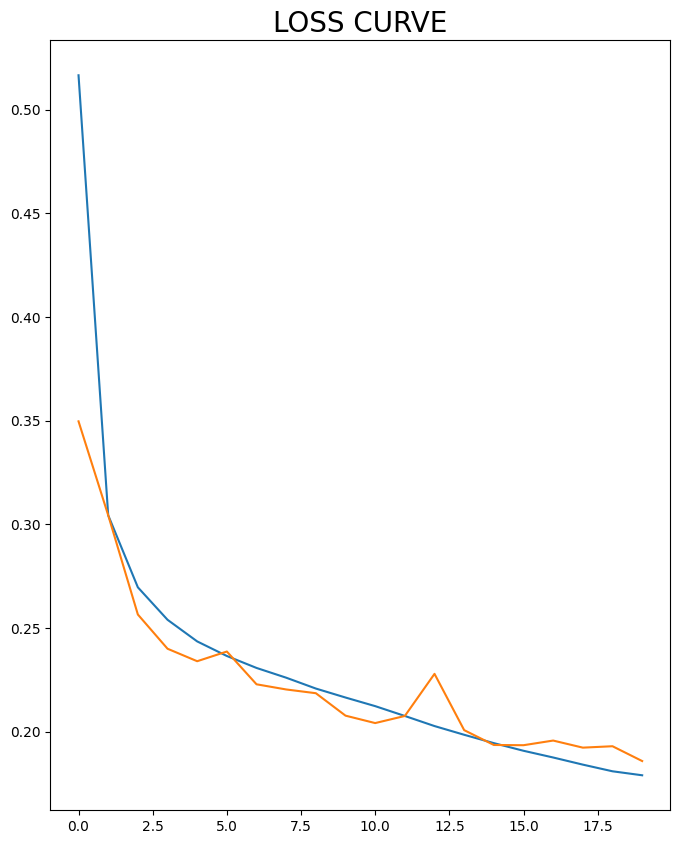

In [17]:
plt.figure(figsize=(8,10))
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [18]:
model.evaluate(test_text_pad, test_output)

1451/1451 [==============================] - 12s 8ms/step - loss: 0.1859 - accuracy: 0.9293


[0.18587173521518707, 0.9292685389518738]

In [19]:
model.save('./model',overwrite=True)

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets
